# N01. Proyección (predicción) del MEI (Índice Multivariado El Niño)
Para leer los datos del MEI se pueden descargar desde el siguiente enlace:
https://psl.noaa.gov/enso/mei/data/meiv2.data


## 1. Descarga, salva y grafica los índices MEI históricos
Se descargan los índices MEI históricos de "https://psl.noaa.gov/enso/mei/data/meiv2.data".

In [242]:
#*******************************************************************************       
# 1.1. Carga paquetes Python requeridos.
#*******************************************************************************
import numpy as np
import pandas as pd
import datetime as dt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import matplotlib.pyplot as plt
%matplotlib widget
pd.options.plotting.backend = "plotly"

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import seaborn as sns


In [70]:
#*******************************************************************************
# 1.2. Descarga el archivo de índices MEI y lo salva.
#*******************************************************************************
# 1.2.1. Importa la librería requests
import requests
URL = "https://psl.noaa.gov/enso/mei/data/meiv2.data"
# 1.2.2. Descarga el dato en el URL.
response = requests.get(URL)
# 1.2.3. Salva la respuesta en un nuevo archivo llamado meiv2.txt
open("csv/meiv2.csv", "wb").write(response.content)
#*******************************************************************************
meiA = pd.read_csv("csv/meiv2.csv", delim_whitespace=True, skiprows=1, 
                  skipfooter=4, engine='python', names=['anio', '01', '02', 
                  '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])
#*******************************************************************************
meiL = pd.melt(meiA, id_vars= ["anio"],
              value_vars= ["01", "02", "03", "04", "05", "06", "07", "08", 
                       "09", "10", "11", "12"], 
                       var_name="bimes", value_name='mei'
        )
#*******************************************************************************
meiL['anio'] = meiL['anio'].apply(str)
meiL["anioMes"] = meiL['anio'] + "-" + meiL['bimes'] + "-01 00:00:00"
meiL["anioMes"] = pd.to_datetime(meiL["anioMes"])
meiL = meiL.set_index("anioMes")
meiL = meiL.loc[:, ["mei"]]
meiL = meiL.sort_index()
meiL = meiL[meiL['mei']!=-999.00]
#*******************************************************************************
#1.2.4. Salva el meiL en formato parquet. Es más comprimido y mantiene formatos.
#meiL.to_csv("csv/meiL.csv")
meiL.to_parquet("parquet/meiL.parquet.gzip", compression='gzip', engine='fastparquet') 

In [72]:
#*******************************************************************************
# 1.3. Lee el archivo meiL que está en formato parquet.
#*******************************************************************************
meiL = pd.read_parquet('parquet/meiL.parquet.gzip', engine='fastparquet')

In [74]:
# meiL

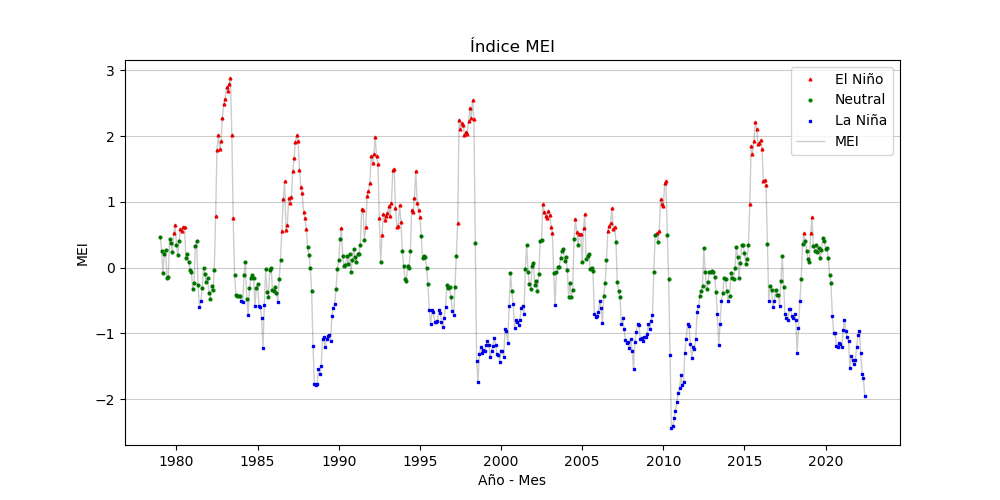

In [75]:
#*******************************************************************************
# 1.4. Grafica los índices meiL.
#*******************************************************************************
ind = np.arange(522)
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
#p1 = ax1(ind, eventosSTRCausaTotal.values)
ax1.set_title ('Índice MEI')
ax1.set_ylabel ('MEI')
ax1.set_xlabel ('Año - Mes')
#ax1.set_xticks(ind, labels=meiL.etiquetaX, rotation=90, fontsize=7)
#plt.xticks(rotation=90)
#
superior = 0.5
inferior = -0.5
nino = np.ma.masked_where(meiL.mei < superior, meiL.mei) #La máscara borra dato.
nina = np.ma.masked_where(meiL.mei > inferior, meiL.mei)
neutral = np.ma.masked_where((meiL.mei <= inferior) | (meiL.mei >= superior), meiL.mei)
ax1.plot(meiL.index, nino, 'r^', label='El Niño', markersize=2)
ax1.plot(meiL.index, neutral, 'go', label='Neutral', markersize=2)
ax1.plot(meiL.index, nina, 'bs', label='La Niña', markersize=2)
ax1.plot(meiL.index, meiL.mei, 'k-', label='MEI', linewidth=1, alpha=0.2)
plt.legend(loc='best')
plt.grid(axis='y', color='k', alpha=0.2)
plt.show()

## 2. Proyecta los índices MEI
Se cuenta con 522 datos de MEI mensuales (bimensuales). Se desean proyectar los valores de MEI para los 6 meses de 2022 y para los 72 meses de los próximos seis años, hasta diciembre de 2028. En total se desea hacer la proyección de 78 meses.
Por eso, los índices de los primeros 444 meses conformarán el conjunto de 'train' (entrenamiento) y los datos de los últimos 78 meses constituirán el conjunto de 'test' (prueba). 

### 2.1. Aplica la descomposición al conjunto 'train'

In [231]:
##***Siempre debo usar el kernel de Anaconda 'base(Python 3.9.12)'
#*******************************************************************************
# 2.1.1. Lee el archivo meiL que está en formato parquet.
#*******************************************************************************
meiL = pd.read_parquet('parquet/meiL.parquet.gzip', engine='fastparquet')
#*******************************************************************************
# 2.1.2. Crea conjuntos 'train' y 'test'.
#*******************************************************************************
# train = meiL.iloc[0:-78] # Los primeros 444 meses.
# test = meiL.iloc[-78:] # Los últimos 78 meses.
# train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)

In [125]:
meiL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 522 entries, 1979-01-01 to 2022-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mei     522 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB


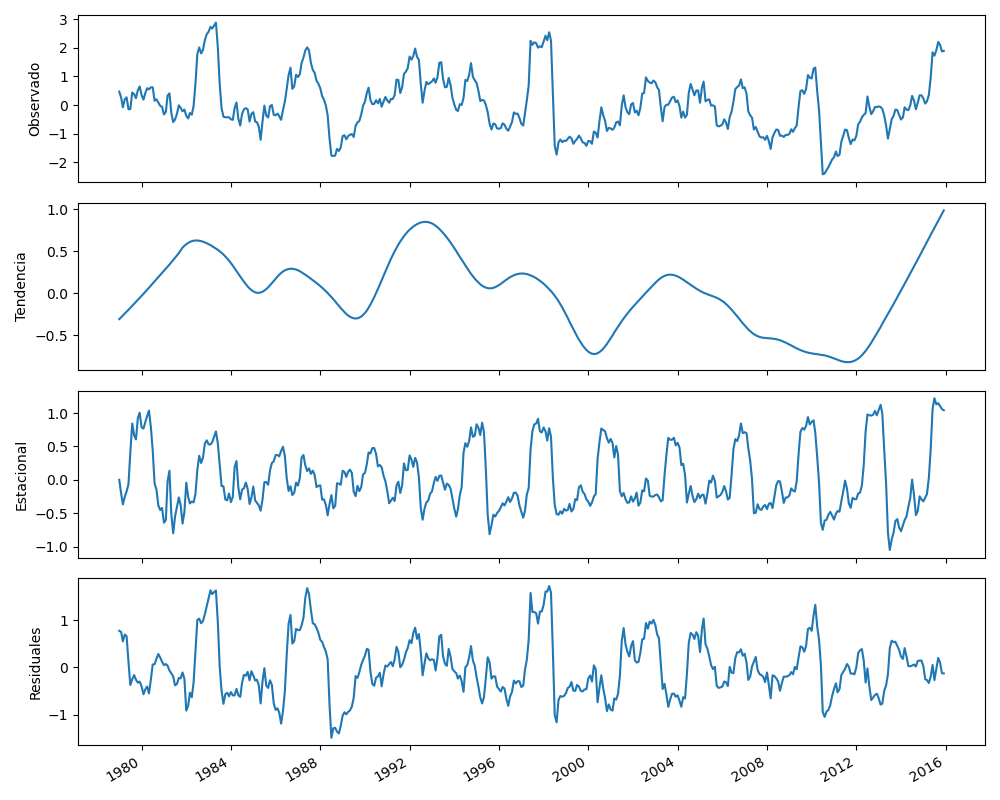

In [90]:
from statsmodels.tsa.seasonal import STL

decomposition = STL(train, period=36).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observado')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Tendencia')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Estacional')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuales')

#plt.xticks(np.arange(0, 444, 12), np.arange(1979, 2016, 1))

fig.autofmt_xdate()
plt.tight_layout()

#plt.savefig('figures/CH08_F04_peixeiro.png', dpi=300)

No se observa ninguna tendencia, aplicaremos el método ARMA, sin Integración, basado en el capítulo 6 de Peixeiro:

* ¿Es estacionaria? Si no lo es, aplique transformaciones.
* Grafique ACF.
* Hay autocorrelación? Si no hay, es una caminata aleatoria.
* Los coefientes de correlación se vuelven abruptamente no significantes después del retardo q? Si es sí, entonces es un proceso MA(q). 
* Si no, grafique PACF.
* Los coeficientes de de Autocorrelación llegan a ser abruptamente no significantes después del retardo p. Si sí, entonces es un proceso AR(p). Si nó, no es un proceso AR(p).

#### 2.2. Chequea si la serie es estacionaria
Se aplica la prueba Dickey-Fuller aumentada.

In [92]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(train) #A
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.026497706022353
p-value: 1.9663682231950188e-05


Como el valor de ADF es un 'número grande negativo' (-5) y el valor p (1,9 * 10 E-5) tiene un valor mucho más pequeño que 0.05, se puede concluir preliminarmente que la serie de tiempo del MEI es estacionaria.

A continuación se graficará el ACF para verificar que se puede inferir el orden del promedio movil de un posible proceso ARMA.

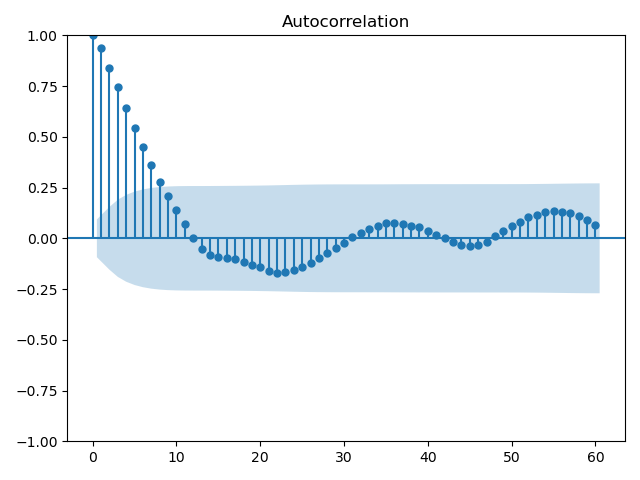

In [93]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train, lags=60);
plt.tight_layout()

Se observa un patrón senoidal en los coeficientes, lo cual significa que hay un proceso AR(p) en juego.
Por otro lado, el último coeficiente significante es el del retardo 8, el cual no cae abruptamente, lo cual no nos indica aún cual es el orden del componente MA.

Avanzamos, para graficar la función de autocorrelación parcial (PACF) con el fin de ver si podemos encontrar el orden del proceso estacionario AR(p).

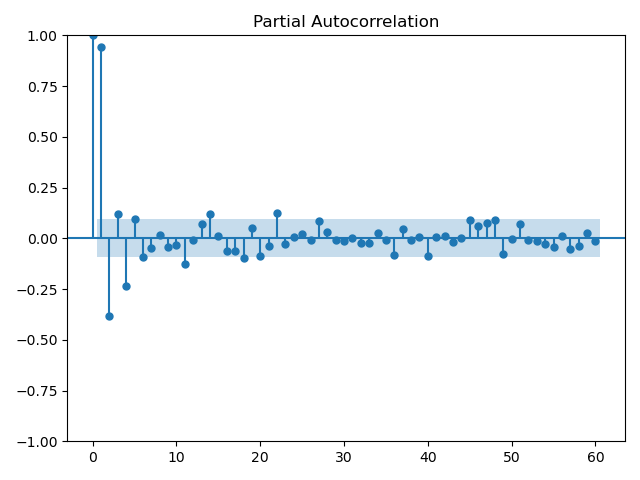

In [94]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train, lags=60)
plt.tight_layout()

No hay un corte claro entre los coeficientes significantes y no significantes. Pareciera presentarse un patrón senoidal de los coeficientes. No se puede inferir el orden p del proceso AR(p).

Sin embargo, si el procceso es estacionario y los gráficoa ACF y PACF muestran un comportamiento senoidal en los valores de los coeficientes se dice que que este es un proceso ARMA(p, q).

Ahora, lo que sigue es determinar el orden p y q del proceso.

In [118]:
#Se van a realizar evaluaciones del modelo con diferentes combinaciones de p y q.
#Se escogerán las combinaciones de p y q que ofrezca n el menor AIC.
ps = range(0, 36, 1)
qs = range(0, 36, 1)
order_list = list(product(ps, qs))
# order_list

In [119]:
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), \
                simple_differencing=False, enforce_invertibility=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [120]:
result_df = optimize_ARMA(train, order_list)
result_df

  0%|          | 0/1296 [00:00<?, ?it/s]

c:\Users\ericd\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ericd\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ericd\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ericd\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ericd\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

,"(p,q)",AIC
0,"(28, 16)",90.000000
1,"(35, 21)",114.000000
2,"(0, 13)",153.584440
3,"(2, 11)",154.977195
4,"(7, 12)",155.168344
...,...,...
1289,"(30, 14)",7039.367305
1290,"(15, 6)",8352.386303
1291,"(29, 14)",8379.708937
1292,"(28, 14)",9592.771449


In [136]:
result_df.to_csv("csv/result_df.csv")
#result_df.to_parquet("parquet/result_df.parquet.gzip", compression='gzip', engine='fastparquet')
#result_df.columns = ['p_q', 'AIC']
#result_df

In [158]:
# model = SARIMAX(train, order=(28,0,16), simple_differencing=False)
# model_fit = model.fit(disp=False)
# residuals = model_fit.resid
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    mei   No. Observations:                  444
Model:             SARIMAX(28, 0, 16)   Log Likelihood                 -51.438
Date:                Thu, 04 Aug 2022   AIC                            192.876
Time:                        20:28:31   BIC                            377.188
Sample:                    01-01-1979   HQIC                           265.561
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4976      5.624      0.088      0.929     -10.525      11.520
ar.L2         -0.1484      2.151     -0.069      0.945      -4.364       4.067
ar.L3          0.1105      2.650      0.042      0.9

In [147]:
residuals.plot()

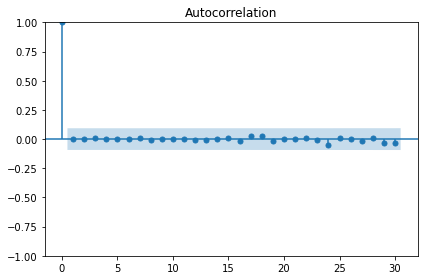

In [148]:
plot_acf(residuals, lags=30);
plt.tight_layout()

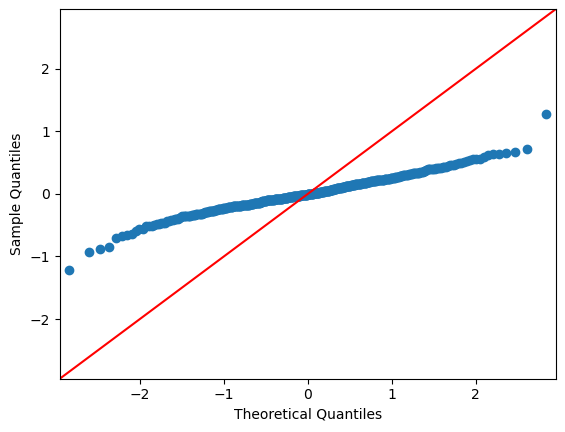

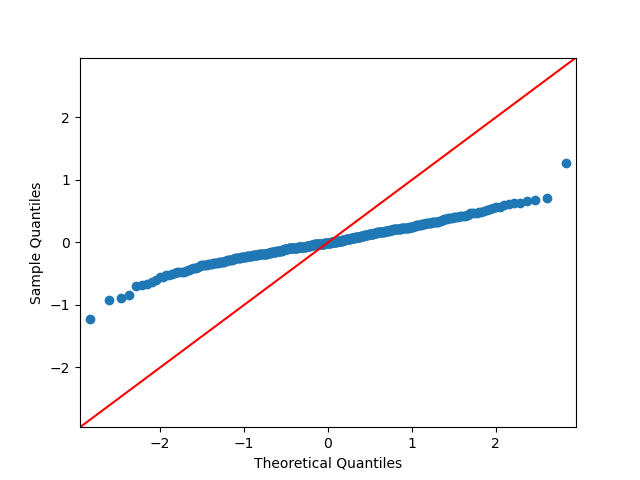

In [138]:
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='45')

In [156]:
#model_fit.plot_diagnostics(figsize=(10, 8));

In [154]:
#from statsmodels.stats.diagnostic import acorr_ljungbox
#lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1)) #A
acorr_ljungbox(residuals, np.arange(1, 11, 1))
#pvalue excede 0.05, los residuales no están correlacionados.

,lb_stat,lb_pvalue
1,0.000086,0.992589
2,0.002657,0.998673
3,0.017724,0.999376
4,0.027136,0.999909
5,0.029682,0.999992
6,0.029685,0.999999
7,0.044638,1.000000
8,0.053452,1.000000
9,0.055771,1.000000
10,0.065765,1.000000


### Pronostica el MEI

In [ ]:
#Ajusta la longitud de 'test' a 80.
# test = test.reset_index()
# test.loc[78, 'anioMes'] = pd.to_datetime('2022-07-01 00:00:00')
# test.loc[79, 'anioMes'] = pd.to_datetime('2022-08-01 00:00:00')
# test = test.set_index('anioMes')
# test

In [342]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [314]:
#train[396:444]

In [328]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(train, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(train, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(train, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.tail()

,mei,pred_mean,pred_last_value,pred_ARMA
anioMes,,,,
2022-04-01,-1.61,0.015788,1.9,-2.516613e-09
2022-05-01,-1.68,0.015788,1.9,-8.270518e-10
2022-06-01,-1.95,0.015788,1.9,4.890661e-10
2022-07-01,NaN,0.015788,1.9,1.097200e-09
2022-08-01,NaN,0.015788,1.9,1.057573e-09


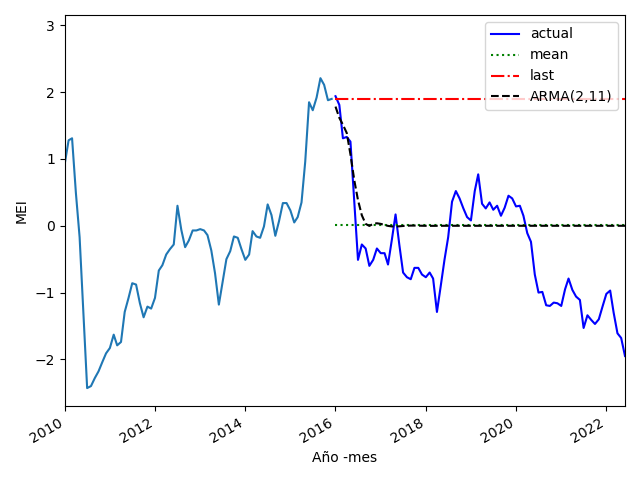

In [329]:
fig, ax = plt.subplots()

ax.plot(train['mei'])
ax.plot(test['mei'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(0,1) diferencial')

ax.legend(loc=1)

ax.set_xlabel('Año -mes')
ax.set_ylabel('MEI')

ax.axvspan(445, 524, color='#808080', alpha=0.2)

ax.set_xlim('2010-01-01', '2022-06-01')

# plt.xticks(
#     [9802, 9850, 9898, 9946, 9994],
#     ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()


## Con el DataFrame diferenciado

In [332]:
#mei_diff = np.diff(meiL.mei, n=1)
df_diff = pd.DataFrame({'mei_diff': mei_diff})
df_diff.plot()

In [333]:
ADF_result = adfuller(mei_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -8.83156664348737
p-value: 1.7640589453588176e-14


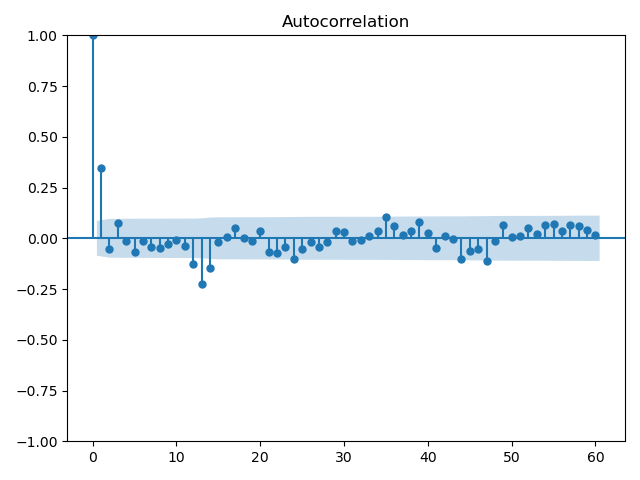

In [334]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(mei_diff, lags=60); #A
plt.tight_layout()

In [338]:
# train = df_diff.iloc[0:-78] # Los primeros 444 meses.
test = df_diff.iloc[-78:] # Los últimos 78 meses
test

,mei_diff
443,0.04
444,-0.13
445,-0.50
446,0.02
447,-0.07
...,...
516,0.05
517,-0.33
518,-0.31
519,-0.07


In [345]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(train, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(train, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(train, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.tail()

C:\Users\ericd\AppData\Local\Temp\ipykernel_25236\4087760079.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ericd\AppData\Local\Temp\ipykernel_25236\4087760079.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ericd\AppData\Local\Temp\ipykernel_25236\4087760079.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,mei_diff,pred_mean,pred_last_value,pred_ARMA
516,0.05,0.003228,0.02,1.289776e-26
517,-0.33,0.003228,0.02,6.300834e-27
518,-0.31,0.003228,0.02,3.078093e-27
519,-0.07,0.003228,0.02,1.503715e-27
520,-0.27,0.003228,0.02,7.345970e-28


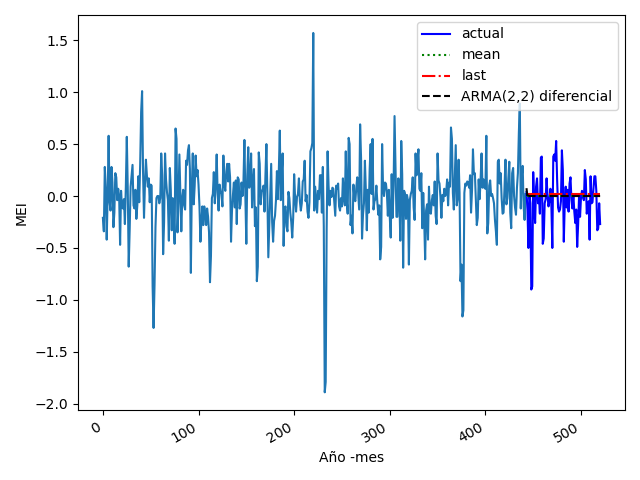

In [346]:
fig, ax = plt.subplots()

ax.plot(train['mei_diff'])
ax.plot(test['mei_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2) diferencial')

ax.legend(loc=1)

ax.set_xlabel('Año -mes')
ax.set_ylabel('MEI')

#ax.axvspan(445, 524, color='#808080', alpha=0.2)

#ax.set_xlim('2010-01-01', '2022-06-01')

# plt.xticks(
#     [9802, 9850, 9898, 9946, 9994],
#     ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()


### 3. Automatizando el pronóstico de series de tiempo con Prophet
Basado en el capítulo 19 del libro 'Time Series Forecasting in Python'.

#### 3.1. Repaso de las librerías de pronosticación automática
Un repaso del ecosistema de pronosticación automática:

* Pmdarima: http://alkaline-ml.com/pmdarima/modules/classes.html
* Prophet : https://facebook.github.io/prophet/,  Paper: (https://arxiv.org/abs/2111.15397), Paper: (https://peerj.com/preprints/3190/).
* NeuralProphet : https://neuralprophet.com/html/index.html
* PyTorch Forecasting: https://pytorch-forecasting.readthedocs.io/en/stable/

#### 3.2. Explorando Prophet
Prophet implementa un modelo aditivo general donde cada serie de tiempo es modelado como una combinación lineal de: una tendencia (g(t)), un componente estacional (s(t)), un efecto de días festivos (h(t)) y un término de error normalmente distribuido.

#### 3.3. Pronosticación básica con Prophet

Prophet espera tener como entrada un DataFrame con dos columnas: una columna de fecha - hora llamada **ds** y una columna llamada **y**. La columna **ds** debe tener un formato aceptado por **pandas**, usualmente YYYY-MM-DD o YYYY-MM-DD HH:MM:SS. La columna **y** contiene los valores a ser pronosticados y deben ser numéricos, ya sea float o integer.
Por ello, en la mayoría de los casos, las columnas deben ser renombradas:

df.columns = ['ds', 'y']

In [19]:
##***Siempre debo usar el kernel de Anaconda 'base(Python 3.9.12)'
#*******************************************************************************
# 3.3.1. Lee el archivo meiL que está en formato parquet.
#*******************************************************************************
# meiL = pd.read_parquet('parquet/meiL.parquet.gzip', engine='fastparquet')
#*******************************************************************************
# 3.3.2. Crea DataFrame con columnas 'ds' y 'y'.
#*******************************************************************************
# meiP = meiL
# meiP = meiP.reset_index()
# meiP.columns = ['ds', 'y']
# meiP
#*******************************************************************************
# 3.3.3. Crea conjuntos 'train' y 'test'.
#*******************************************************************************
# train = meiP.iloc[0:-78] # Los primeros 444 meses.
# test = meiP.iloc[-78:] # Los últimos 78 meses.
# train
# test

* Prophet sigue la metodología de la API de 'sklearn', donde un modelo es primero inicializado mediante la creación de una instancia de la clase Prophet. 

* Luego, el modelo es entrenado usando el método 'fit'. 

* Posteriormente, las predicciones son generadas usando el método 'predict'.

In [23]:
#*******************************************************************************
# 3.3.4. Carga el paquete Prophet.
#*******************************************************************************
from prophet import Prophet
#*******************************************************************************
# 3.3.5. Carga el  modelo m como una instancia de Prophet.
#*******************************************************************************
m = Prophet()
#*******************************************************************************
# 3.3.6. Ajustamos el modelo sobre el conjunto de entrenamiento.
#*******************************************************************************
m.fit(train) #El modelo está listo para pronosticar.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
future = m.make_future_dataframe(periods=79, freq='MS')

In [30]:
#Generamos las predicciones.
forecast = m.predict(future)

In [57]:
forecast.loc[[0, 60, 120, 180, 240, 300, 360, 420, 480], 'ds']

0     1979-01-01
60    1984-01-01
120   1989-01-01
180   1994-01-01
240   1999-01-01
300   2004-01-01
360   2009-01-01
420   2014-01-01
480   2019-01-01
Name: ds, dtype: datetime64[ns]

In [40]:
test.loc[:, ('yhat', 'yhat_lower', 'yhat_upper')] = forecast.loc[:, ('yhat', 'yhat_lower', 'yhat_upper')]
#test.loc[444:522, ['yhat', 'yhat_lower', 'yhat_upper']]
#forecast[['yhat', 'yhat_lower', 'yhat_upper']]
#test

C:\Users\ericd\AppData\Local\Temp\ipykernel_25236\2495598267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, ('yhat', 'yhat_lower', 'yhat_upper')] = forecast.loc[:, ('yhat', 'yhat_lower', 'yhat_upper')]


In [51]:
test.loc[:, 'baseline'] = train['y'].iloc[-1]


C:\Users\ericd\AppData\Local\Temp\ipykernel_25236\1840887933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'baseline'] = train['y'].iloc[-1]


In [52]:
from sklearn.metrics import mean_absolute_error
mae_lineaBase = mean_absolute_error(test['y'], test['baseline'])
mae_prophet = mean_absolute_error(test['y'], test['yhat'])
print(mae_prophet)
print(mae_lineaBase)

0.6557102412334468
2.2841025641025636


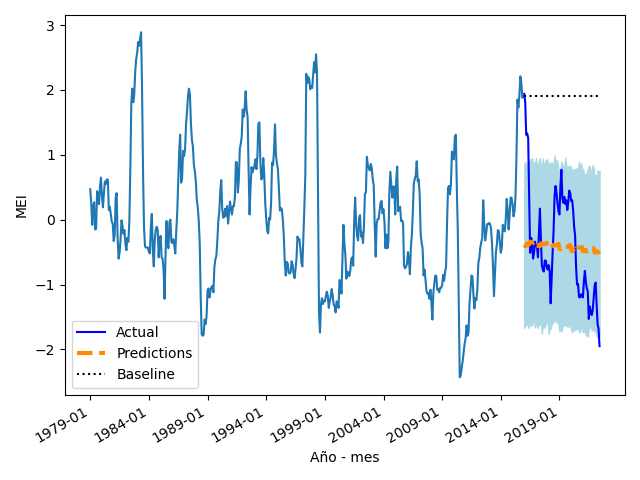

In [59]:
fig, ax = plt.subplots()
ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')
ax.plot(test['baseline'], 'k:', label='Baseline')
ax.set_xlabel('Año - mes')
ax.set_ylabel('MEI')
# ax.axvspan(3285, 3649, color='#808080', alpha=0.1)
ax.legend(loc='best')
plt.xticks(
[0, 60, 120, 180, 240, 300, 360, 420, 480],
['1979-01', '1984-01', '1989-01', '1994-01','1999-01','2004-01', '2009-01', '2014-01', '2019-01'])
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'],
color='lightblue')
# plt.xlim(3200, 3649)
fig.autofmt_xdate()
plt.tight_layout()

No resultó una predicción razonable.